In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial,freesans'

from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
import pathlib
import astropy.coordinates
from astropy.coordinates import AltAz, FK5, Galactic
import astropy.units as u
import astropy.time
import astropy.constants as c
import xarray as xr
import pickle
import time
import os
import sys
import multiprocessing
import necstdb
sys.path.append('/home/amigos/otf_yamada/_python_modules/analy_n2data/script')
#sys.path.append("/home/amigos/git/analy_n2data/script")
#import coordinate_calc
import kisa_rev
from datetime import datetime

In [2]:
tp_topics = [
        'xffts_power_board01',
        'xffts_power_board02',
        'xffts_power_board03',
        'xffts_power_board04',
        'xffts_power_board05', 
        'xffts_power_board06',
        'xffts_power_board07',
        'xffts_power_board08',
        'xffts_power_board09',
        'xffts_power_board10', 
        'xffts_power_board11',
        'xffts_power_board12',
        'xffts_power_board13', 
        'xffts_power_board14', 
        'xffts_power_board15',
        'xffts_power_board16',
        'ac240_tp_data_1',
        'ac240_tp_data_2'
]

board2hz = {
        'xffts_power_board01': '100beam',
        'xffts_power_board02': '100beam',
        'xffts_power_board03': '100beam',
        'xffts_power_board04': '100beam',
        'xffts_power_board05': '100beam', 
        'xffts_power_board06': '100beam',
        'xffts_power_board07': '100beam',
        'xffts_power_board08': '100beam',
        'xffts_power_board09': '100beam',
        'xffts_power_board10': '100beam', 
        'xffts_power_board11': '100beam',
        'xffts_power_board12': '100beam',
        'xffts_power_board13': '100beam', 
        'xffts_power_board14': '100beam', 
        'xffts_power_board15': '100beam',
        'xffts_power_board16': '100beam',
        'ac240_tp_data_1': '200beam', 
        'ac240_tp_data_2': '200beam', 
}

In [38]:
path = '/mnt/usbdisk9/data/observation/otf/otf_2019/n20200320193251_12CO_2-1_otf_OriKL'
#path = "/home/amigos/seigyo/hdd2/copy_HDD4_201912/otf_2019/n20191218021902_12CO_2-1_otf_OriKL/"

In [39]:
xFFTS_Data_topics = [
    'xffts_board01'
    'xffts_board02'
    'xffts_board03'
    'xffts_board04'
    'xffts_board05'
    'xffts_board06'
    'xffts_board07'
    'xffts_board08'
    'xffts_board09'
    'xffts_board10'
    'xffts_board11'
    'xffts_board12'
    'xffts_board13'
    'xffts_board14'
    'xffts_board15'
    'xffts_board16'
    
]

In [40]:
db = necstdb.opendb(path)
enc = db.open_table('status_encoder').read(astype='array')
#weather= db.open_table('status_weather').read(astype='array')

In [41]:
enc['enc_az']/3600

array([72.48638136, 72.48634322, 72.48638136, ..., 54.23781356,
       54.23777542, 54.23773729])

In [42]:
xffts = db.open_table('xffts_board01').read(astype='array')

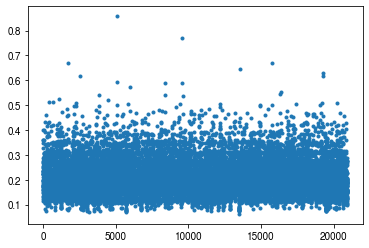

In [43]:
plt.plot(xffts['received_time'][1:]-xffts['received_time'][:-1], '.')

(0.0, 0.2)

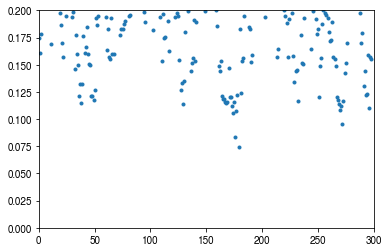

In [44]:
plt.plot(xffts['received_time'][1:]-xffts['received_time'][:-1], '.')
plt.xlim(0,300)
plt.ylim(0.0,0.2)

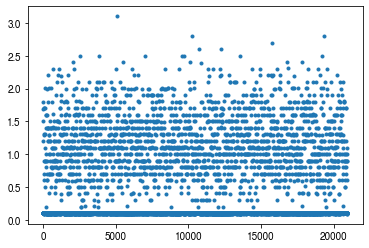

In [45]:
plt.plot(xffts['timestamp'][1:]-xffts['timestamp'][:-1], '.')

(0, 300)

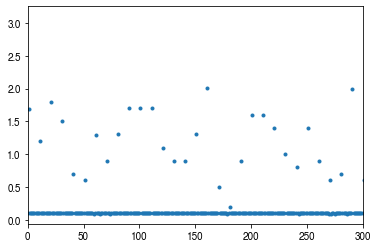

In [46]:
plt.plot(xffts['timestamp'][1:]-xffts['timestamp'][:-1], '.')
plt.xlim(0,300)

(0, 50)

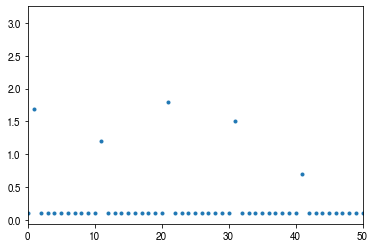

In [47]:
plt.plot(xffts['timestamp'][1:]-xffts['timestamp'][:-1], '.')
plt.xlim(0,50)

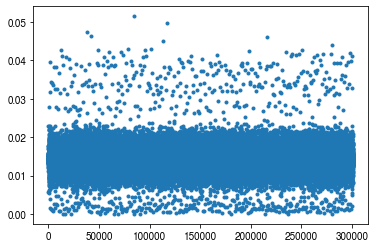

In [51]:
plt.plot(enc['received_time'][1:]-enc['received_time'][:-1], '.')

(0, 300)

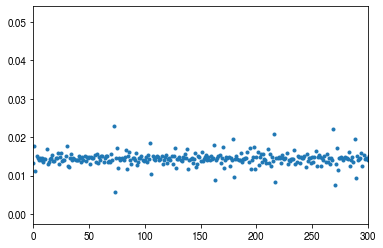

In [52]:
plt.plot(enc['received_time'][1:]-enc['received_time'][:-1], '.')
plt.xlim(0,300)
#plt.ylim(0., 0.02)

In [220]:
def get_array(path, xFFTS_Data_topics):
    db = necstdb.opendb(path)
    xFFTS_data = db.open_table('xffts_board01').read(astype='array')
    obsmode =  db.open_table('obsmode').read(astype='array')
    enc =  db.open_table('status_encoder').read(astype='array')
    
    spec_array = xr.DataArray(

        xFFTS_data['spec'], 
        dims=['t', 'spectral_data'], 
        coords={'t':xFFTS_data['received_time']}
    )


    obsmode_array = xr.DataArray(

        obsmode['obs_mode'],
        dims = ['t'],
        coords={'t':obsmode['received_time'], 'scan_num':('t', obsmode['scan_num'])}


    )
    
    az_array = xr.DataArray(
        
        enc['enc_az']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )
    
    el_array = xr.DataArray(
        
        enc['enc_el']/3600, 
        dims=['t'],
        coords={'t':enc['timestamp']}
    )

    return spec_array, obsmode_array, az_array, el_array

def concatenate(spec_array, obsmode_array, az_array, el_array):
    
    spec_array['t'] = np.float128(spec_array['t'])
    obsmode_array['t'] = np.float128(obsmode_array['t'])
    
    reindexed_obsmode_array = obsmode_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_az_array = az_array.reindex(t=spec_array['t'], method='backfill')
    reindexed_encoder_el_array = el_array.reindex(t=spec_array['t'], method='backfill')
    
    del obsmode_array
    del az_array
    del el_array
    raw_array = xr.DataArray(
        np.array(spec_array),
        dims=['t', 'spectral_data'],
        coords={'t':spec_array['t'],
                
               'obsmode':('t',np.array(reindexed_obsmode_array)),
               'azlist':('t', np.array(reindexed_encoder_az_array)),
               'ellist':('t', np.array(reindexed_encoder_el_array))
                
               }
    )
    
    return raw_array

def get_lb(raw_array, time, location):
    AltAzcoordiantes = astropy.coordinates.SkyCoord(
        
        az=raw_array['azlist'], 
        alt=raw_array['ellist'], 
        frame='altaz', 
        obstime=time,
        location=location, 
        unit='deg')
    
    l_list = AltAzcoordiantes.transform_to(Galactic).l
    b_list = AltAzcoordiantes.transform_to(Galactic).b
    return l_list, b_list

def make_data_array(raw_array, l_list, b_list):
    data_array = xr.DataArray(
        np.array(raw_array), 
        dims=['t', 'spectral_data'],
        coords={'t':raw_array['t'],
               'obsmode':('t',np.array(raw_array['obsmode'])),
               'l_list':('t', l_list),
               'b_list':('t', b_list)}
    )
    return data_array

In [192]:
path = "/home/amigos/seigyo/hdd2/copy_HDD4_201912/otf_2019/n20191218021902_12CO_2-1_otf_OriKL/"

In [193]:
spec_array, obsmode_array, az_array, el_array = get_array(path, xFFTS_Data_topics[0])

In [201]:
spec_array

<xarray.DataArray (t: 41213, spectral_data: 32768)>
array([[1.2767457e+10, 1.2767457e+10, 1.2767457e+10, ..., 4.8993449e+11,
        4.9475548e+11, 4.9591711e+11],
       [1.2548665e+10, 1.2548665e+10, 1.2548665e+10, ..., 4.7412891e+11,
        4.7687572e+11, 5.0116133e+11],
       [1.2493777e+10, 1.2493777e+10, 1.2493777e+10, ..., 4.7962879e+11,
        4.8467493e+11, 5.0033272e+11],
       ...,
       [1.2600665e+10, 1.2600665e+10, 1.2600665e+10, ..., 4.6949338e+11,
        4.6883589e+11, 4.6221260e+11],
       [1.2633879e+10, 1.2633879e+10, 1.2633879e+10, ..., 4.5304870e+11,
        4.6605661e+11, 4.6742461e+11],
       [1.2769579e+10, 1.2769579e+10, 1.2769579e+10, ..., 4.6850510e+11,
        4.6777470e+11, 4.6424546e+11]], dtype=float32)
Coordinates:
  * t        (t) float64 1.577e+09 1.577e+09 1.577e+09 ... 1.577e+09 1.577e+09
Dimensions without coordinates: spectral_data

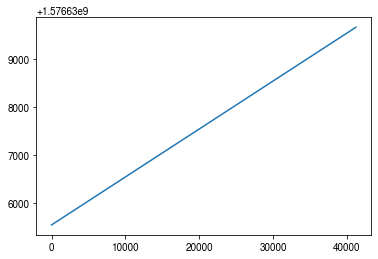

In [200]:
plt.plot(spec_array['t'])

In [221]:
raw_array = concatenate(spec_array, obsmode_array, az_array, el_array)

ValueError: index must be monotonic increasing or decreasing

In [161]:
time = [datetime.utcfromtimestamp(i) for i in np.array(narray['t'])]

nanten2 = astropy.coordinates.EarthLocation(
        lon =  -67.70308139 * u.deg,
        lat = -22.96995611  * u.deg,
        height = 4863.85 * u.m
    )

In [162]:
l_list, b_list = get_lb(raw_array, time=time, location=nanten2)

In [163]:
data_array = make_data_array(raw_array, l_list,b_list)

In [170]:
onmask = data_array['obsmode'] == b'ON        '

In [171]:
np.unique(data_array['obsmode'])

array([b'          ', b'HOT       ', b'OFF       ', b'ON        '],
      dtype='|S12')

In [173]:
l_on = data_array[onmask]['l_list']
b_on = data_array[onmask]['b_list']

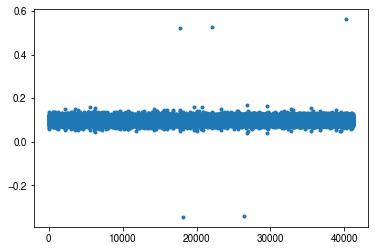

In [195]:
timestamp_list = np.array(spec_array['t'])
plt.plot(timestamp_list[1:]-timestamp_list[:-1], '.')

(0, 30)

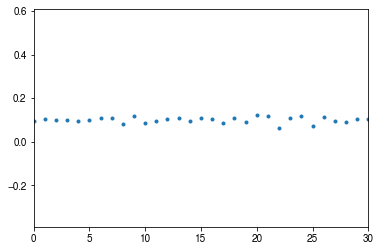

In [196]:
plt.plot(timestamp_list[1:]-timestamp_list[:-1],'.')
plt.xlim(0,30)

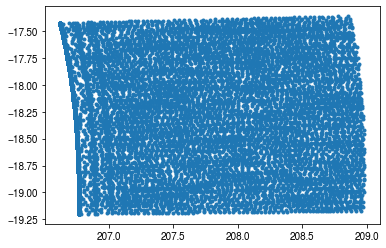

In [174]:
plt.plot(l_on, b_on, '.')

(207.5, 207.75)

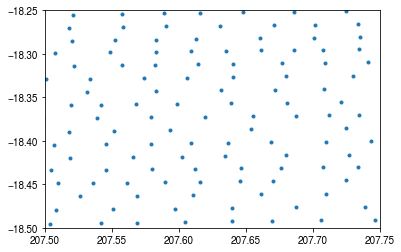

In [175]:
plt.plot(l_on, b_on, '.')
plt.ylim(-18.50, -18.25)
plt.xlim(207.5, 207.75)

In [88]:
# azel to wcs conversion:

nanten2 = astropy.coordinates.EarthLocation(
        lon =  -67.70308139 * u.deg,
        lat = -22.96995611  * u.deg,
        height = 4863.85 * u.m
    )

In [113]:
def atomosphere_correction(raw_array, weather):
    Altaz = AltAz(az=np.array(raw_array['azlist']),
                  alt=np.array(raw_array['ellist']),
                  unit=u.deg,
                  obstime=astropy.time.Time(raw_array['t'], format = 'unix'),
                  pressure=weather['press'].mean()*astropy.units.hPa, 
                  obswl=(astropy.constants.c/(115*astropy.units.GHz)).to('micron'),
                  temperature=(weather['out_temp'].mean() - 273.15)*astropy.units.deg_C,
                  relative_humidity = weather['out_humi'].mean()/100,
                  location = nanten2,
                                                  )
    return Altaz

In [ ]:
SkyCoord()

In [96]:
fixed_target = target.transform_to(Altaz)

In [130]:
time = [datetime.utcfromtimestamp(i) for i in np.array(narray['t'])]

In [131]:
x = get_radec(raw_array=narray, location=nanten2, time=time)

In [141]:
radec_list = x.transform_to(Galactic)

In [143]:
l = radec_list.l
b = radec_list.b

(-19.2, -17.5)

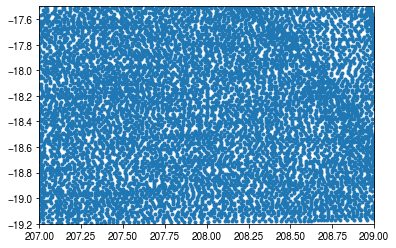

In [151]:
plt.plot(l, b, '.')
plt.xlim(207,209)
plt.ylim(-19.2,-17.50)

(-19.2, -19.0)

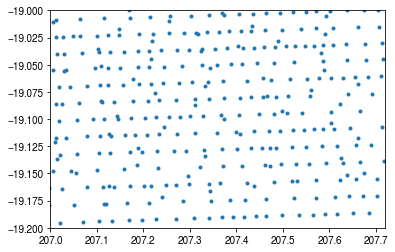

In [152]:
plt.plot(l, b, '.')
plt.xlim(207,207.72)
plt.ylim(-19.2,-19.00)

In [74]:
target = astropy.coordinates.SkyCoord(
        ra = 83.80613 * u.deg,
        dec =  -5.374320 * u.deg,
)

In [75]:
Altaz.transform_to(target)

ValueError: Cannot transform a frame with no data

In [68]:
target

<SkyCoord (GCRS: obstime=[1.58473277e+09 1.58473277e+09 1.58473277e+09 ... 1.58473711e+09
 1.58473711e+09 1.58473711e+09], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    [(0.3425047 , 0.14818119, 0.99610497),
     (0.34250653, 0.14818199, 0.99610497),
     (0.34250823, 0.14818272, 0.99610497), ...,
     (0.38827931, 0.16802254, 0.9961193 ),
     (0.38828128, 0.1680234 , 0.9961193 ),
     (0.38828297, 0.16802413, 0.9961193 )]>

In [ ]:
regrid(spec_array, obsmode_array)

In [155]:
np.unique(obsmode_array)

array([b'          ', b'HOT       ', b'OFF       ', b'ON        '],
      dtype='|S12')

In [125]:
 db.open_table('obsmode').read(astype='array')

array([(1.58473277e+09, b'          ',  61., 0., 0.),
       (1.58473277e+09, b'          ',  61., 0., 0.),
       (1.58473277e+09, b'          ',  61., 0., 0.), ...,
       (1.58473711e+09, b'          ', 121., 0., 0.),
       (1.58473711e+09, b'          ', 121., 0., 0.),
       (1.58473711e+09, b'          ', 121., 0., 0.)],
      dtype=[('received_time', '<f8'), ('obs_mode', 'S12'), ('scan_num', '<f4'), ('lamdel', '<f4'), ('betdel', '<f4')])

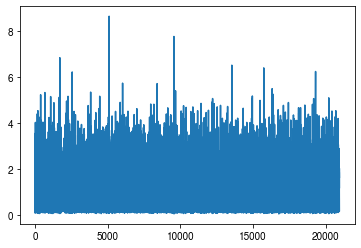

In [116]:
plt.plot((spec['received_time'][1:] - spec['received_time'][:-1])/(spec['timestamp'][1:] - spec['timestamp'][:-1]))

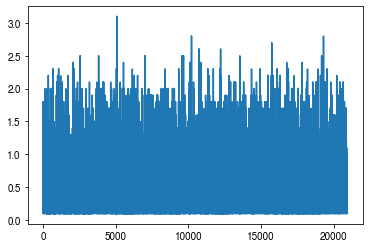

In [114]:
plt.plot(spec['timestamp'][1:] - spec['timestamp'][:-1])

In [101]:
spec['spec'].shape

(20934, 32768)

In [99]:
spec['timestamp'].shape

(20934,)

In [105]:
spec_array

<xarray.DataArray (t: 20934, spectral_data: 32768)>
array([[1.2836528e+10, 1.2836528e+10, 1.2836528e+10, ..., 2.0689477e+12,
        2.1351196e+12, 2.1391624e+12],
       [1.2631030e+10, 1.2631030e+10, 1.2631030e+10, ..., 2.1529649e+12,
        2.1317448e+12, 2.2218458e+12],
       [1.2766928e+10, 1.2766928e+10, 1.2766928e+10, ..., 2.1252916e+12,
        2.1591129e+12, 2.1334309e+12],
       ...,
       [1.3100738e+10, 1.3100738e+10, 1.3100738e+10, ..., 2.0208622e+12,
        2.0203192e+12, 2.0419649e+12],
       [1.2744699e+10, 1.2744699e+10, 1.2744699e+10, ..., 2.0645874e+12,
        1.9841526e+12, 2.0030236e+12],
       [1.3087892e+10, 1.3087892e+10, 1.3087892e+10, ..., 1.9918843e+12,
        2.0448307e+12, 1.9550284e+12]], dtype=float32)
Coordinates:
  * t              (t) float64 1.585e+09 1.585e+09 ... 1.585e+09 1.585e+09
  * spectral_data  (spectral_data) int64 0 1 2 3 4 ... 32764 32765 32766 32767

In [86]:
spec

array([(1.58473277e+09, 1.58473277e+09, [1.28365281e+10, 1.28365281e+10, 1.28365281e+10, 1.28365281e+10, 1.28365281e+10, 4.52160973e+09, 8.37950106e+09, 2.53678510e+10, 3.13795814e+09, 4.67159757e+09, 1.37848699e+10, 3.40681196e+10, 4.70332621e+10, 3.17251200e+09, 8.76279296e+09, 6.57296742e+09, 2.85754112e+09, 4.49906227e+09, 4.29812224e+09, 9.26224691e+09, 1.24283535e+10, 2.83459149e+09, 3.49673318e+09, 2.59608678e+09, 4.55209779e+09, 2.93032218e+09, 2.49584640e+09, 1.71939164e+10, 8.83526963e+09, 2.40310835e+09, 4.86269798e+09, 3.44446054e+09, 2.43656192e+09, 2.94623104e+09, 2.84375117e+09, 7.63094221e+09, 7.97621658e+09, 2.80555392e+09, 2.44418099e+09, 3.07106406e+09, 2.29030861e+09, 2.27395558e+09, 5.97797274e+09, 2.27710259e+09, 7.03341363e+09, 2.32113843e+09, 3.15474611e+09, 2.24623616e+09, 2.18017357e+09, 2.62738150e+09, 2.18744781e+09, 7.96028006e+09, 2.45262694e+09, 2.66687821e+09, 4.10904550e+09, 2.91725107e+09, 2.15570381e+09, 3.04237875e+09, 2.18349261e+09, 2.57474278e+09,

In [51]:
def open_necstdb(path):
    db = necstdb.opendb(path)
    
    tp = {_: db.open_table(_).read(astype='array') for _ in tp_topics}
    tables = {
        'tp':  tp,
        'tp_receivedtime': {_: tp[_]['received_time'][1:] - tp[_]['received_time'][:-1] for _ in tp},
        'tp_timestamp': {_: tp[_]['timestamp'][1:].astype(float) - tp[_]['timestamp'][:-1].astype(float) for _ in tp},
        'load': db.open_table('cpz7415v_1_rsw0_u_step').read(astype='array'),
        'enc': db.open_table('status_encoder').read(astype='array'),
        'obsmode': db.open_table('obsmode').read(astype='array'),
        'weather' : db.open_table('status_weather').read(astype='array')
    }
    
    return tables

def interpret_obsmode(obsmode):
    modeint = numpy.zeros(len(obsmode)) -1
    modeint[obsmode['obs_mode'] == b'HOT       '] = 0
    modeint[obsmode['obs_mode'] == b'OFF       '] = 1
    modeint[obsmode['obs_mode'] == b'ON        '] = 2
    
    obsmodeint = pandas.DataFrame(
                modeint,
                index = pandas.to_datetime(obsmode['received_time'], unit='s'),
                columns = ['obsmode'],
    )
    return obsmodeint


In [9]:
tab = open_necstdb('/mnt/usbdisk9/data/observation/otf/otf_2019/n20200320193251_12CO_2-1_otf_OriKL')

In [60]:
tab

{'tp': {'xffts_power_board01': array([(1.58473277e+09, 1.58473277e+09, 3.57885238e+17),
         (1.58473277e+09, 1.58473277e+09, 3.56721108e+17),
         (1.58473277e+09, 1.58473277e+09, 3.55098651e+17), ...,
         (1.58473711e+09, 1.58473711e+09, 3.82405289e+17),
         (1.58473711e+09, 1.58473711e+09, 3.85933807e+17),
         (1.58473711e+09, 1.58473711e+09, 3.85953295e+17)],
        dtype=[('received_time', '<f8'), ('timestamp', '<f8'), ('total_power', '<f8')]),
  'xffts_power_board02': array([(1.58473277e+09, 1.58473277e+09, 4.02446708e+17),
         (1.58473277e+09, 1.58473277e+09, 4.01775763e+17),
         (1.58473277e+09, 1.58473277e+09, 3.99607662e+17), ...,
         (1.58473711e+09, 1.58473711e+09, 3.98665046e+17),
         (1.58473711e+09, 1.58473711e+09, 4.02450732e+17),
         (1.58473711e+09, 1.58473711e+09, 4.03481854e+17)],
        dtype=[('received_time', '<f8'), ('timestamp', '<f8'), ('total_power', '<f8')]),
  'xffts_power_board03': array([(1.58473277e+09, 1

In [ ]:
#とあるIFについてのXarrayを出すような関数を作成



In [57]:
timestamp = [tab['tp']['xffts_power_board02'][i][0] for i in range(len(tab['tp']['xffts_power_board02']))]
timestamp = numpy.array(timestamp)

obsmode = tab['obsmode']

In [58]:
tab['tp']['xffts_power_board01'].shape

(42532,)

In [48]:
interpret_obsmode(obsmode)

,obsmode
2020-03-20 19:32:53.884041071,-1.0
2020-03-20 19:32:53.927145004,-1.0
2020-03-20 19:32:53.978220940,-1.0
2020-03-20 19:32:54.028578520,-1.0
2020-03-20 19:32:54.077684641,-1.0
...,...
2020-03-20 20:45:12.821467161,-1.0
2020-03-20 20:45:12.871077538,-1.0
2020-03-20 20:45:12.921477556,-1.0
2020-03-20 20:45:12.972053766,-1.0


In [40]:
tab['obsmode'][200]

(1.58473278e+09, b'HOT       ', 0., 0., 0.)

(0, 300)

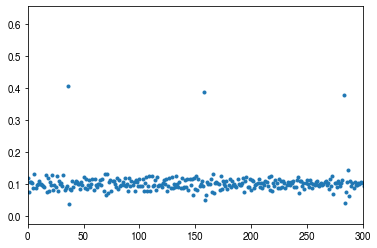

In [35]:
matplotlib.pyplot.scatter(numpy.arange(len(timestamp[1:]-timestamp[:-1])), timestamp[1:]-timestamp[:-1], marker='.')
matplotlib.pyplot.xlim(0,300)